<a href="https://colab.research.google.com/github/sudhir123tiwari/MajorProject/blob/main/UnetBrainTumorSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-net for Brain Tumor Segmentation in MRI.

This notebook contains the implementation of a neural network U-net for brain tumor segmentation in magnetic resonance images. The images and masks used in the training are available at this link: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

* Problem definition

> Brain tumors represent a complex and serious condition that affects millions of individuals worldwide. The diagnosis of these tumors can be a challenging process, especially in cases of small or diffuse tumors. Imaging technology, such as magnetic resonance imaging (MRI), is an important tool for aiding in the diagnosis of brain tumors. However, image analysis can be time-consuming and requires specialized knowledge.

> 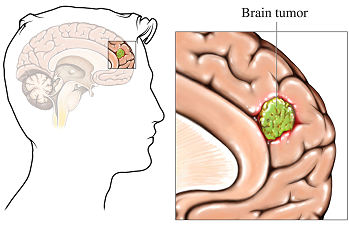

> Image available at: https://www.cityofhope.org/clinical-program/brain-tumors/brain-tumors-facts

* A possible solution

> In this context, the use of artificial intelligence (AI) algorithms emerges as a promising alternative to assist in the identification of brain tumors in MRI images. AI algorithms can be trained to identify specific patterns and features in medical data, aiding in the detection of tumors with greater accuracy and efficiency. Additionally, AI can be used to segment the tumors and classify them according to their degree of malignancy.

> The use of AI algorithms, in conjunction with MRI imaging technology, can provide more accurate and rapid results in the identification and classification of brain tumors. This approach can be particularly useful in emergency situations, where a rapid and accurate diagnosis is essential for clinical decision-making. Moreover, the use of AI in the healthcare field can contribute to the improvement of treatment and care for patients with brain tumors. Therefore, the use of AI algorithms in the identification of brain tumors can have a significant impact on clinical practice, offering more accurate and efficient results for the diagnosis and treatment of these tumors.

> 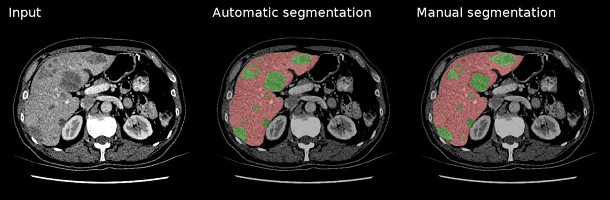

> Image avaliable at: https://paperswithcode.com/task/tumor-segmentation

* The U-Net architecture

> The U-net architecture is a convolutional neural network that has been widely used in medical image segmentation tasks. Initially proposed for the segmentation of biological cell images, its application was extended to the segmentation of brain tumors in MRI images.

> It consists of an encoder and a decoder, connected by a series of convolutional and pooling layers. The encoder is responsible for extracting features from the input image, while the decoder reconstructs the output segmentation map. The U-net also includes skip connections, which allow for the transfer of information from the encoder to the decoder, improving the accuracy of the segmentation. The number of layers and filters used in the U-net can be adjusted to optimize its performance for specific tasks.


> 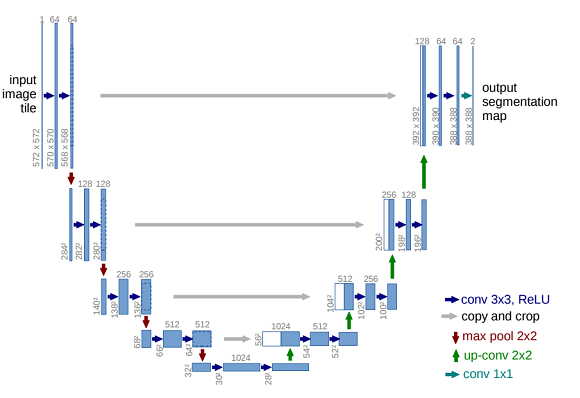

> Image avaliable at: https://arxiv.org/pdf/1505.04597v1.pdf

# Data processing 🔍

As we are working with magnetic resonance images, it is very common for them to be in ".dcm", ".nii" or ".tif". For this reason, we need to pre-process the data before passing it to our neural network.

In [5]:
!pip install kaggle
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download mateuszbuda/lgg-mri-segmentation

100% 713M/714M [00:06<00:00, 146MB/s]
100% 714M/714M [00:07<00:00, 107MB/s]


In [10]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

* Synchronizing the environment with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Importing required libraries and modules

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set Parameters to resize
im_width = 256
im_height = 256

* Saving image names and masks in arrays

In [11]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_5.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_29.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_27.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_7.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_11.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_18.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_26.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_36.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_9.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_1991081

* Data visualization

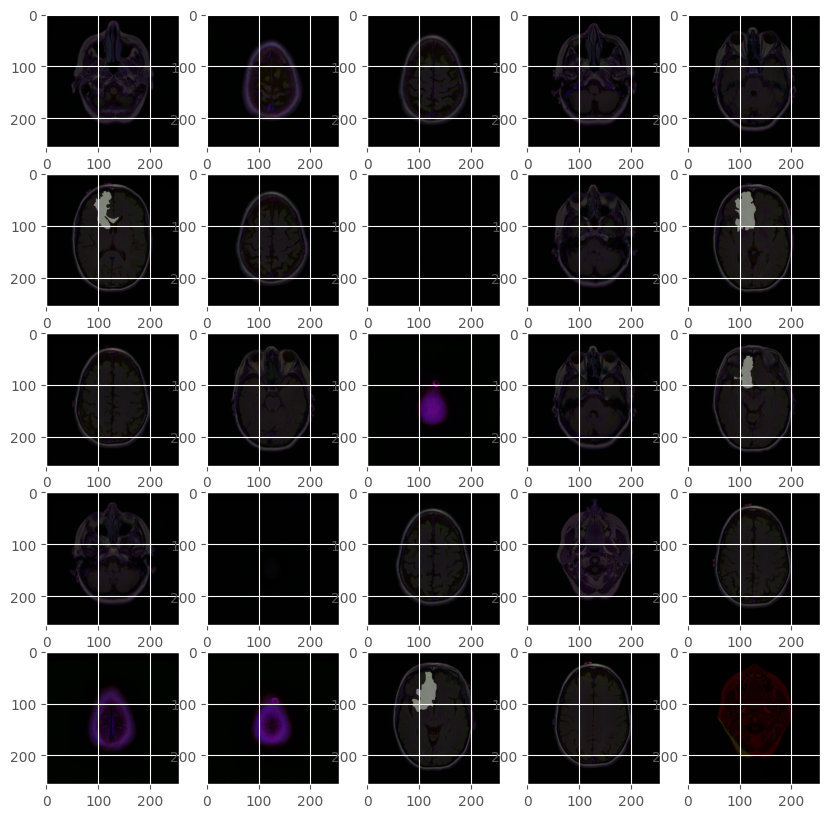

In [12]:
#Lets plot some samples
rows,cols=5,5
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

* Defining training, validation, and testing sets.

In [13]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


* Data pre-processing

In [14]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

* Metrics related to mask overlay on image

In [15]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Jaccard
def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# Defining the architecture of the U-Net model 🧠

In [16]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [17]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

# Training the model ⚙️

In [18]:
EPOCHS = 50
BATCH_SIZE = 42

In [19]:
# Defining training image transformations
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Creating training set using function train_generator() to separate into batches.
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

# Defining the model with input_size and 3 channels
model = unet(input_size=(im_height, im_width, 3))

# Defining the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Setting callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True), early_stop]

# Compiling the model
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# Saving history
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
68/67 [==============================] - ETA: -1s - loss: -0.1094 - binary_accuracy: 0.8981 - iou: 0.0597 - dice_coef: 0.1100Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02236, saving model to unet_brain_mri_seg.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 311s 3s/step - loss: -0.1094 - binary_accuracy: 0.8981 - iou: 0.0597 - dice_coef: 0.1100 - val_loss: -0.0224 - val_binary_accuracy: 0.0137 - val_iou: 0.0113 - val_dice_coef: 0.0224
Epoch 2/50
68/67 [==============================] - ETA: -1s - loss: -0.3746 - binary_accuracy: 0.9871 - iou: 0.2398 - dice_coef: 0.3752
Epoch 2: val_loss improved from -0.02236 to -0.02561, saving model to unet_brain_mri_seg.hdf5
67/67 [==============================] - 157s 2s/step - loss: -0.3746 - binary_accuracy: 0.9871 - iou: 0.2398 - dice_coef: 0.3752 - val_loss: -0.0256 - val_binary_accuracy: 0.1597 - val_iou: 0.0130 - val_dice_coef: 0.0256
Epoch 3/50
68/67 [==============================] - ETA: -1s - loss: -0.5842 - binary_accuracy: 0.9927 - iou: 0.4184 - dice_coef: 0.5829
Epoch 3: val_loss improved from -0.02561 to -0.02944, saving model to unet_brain_mri_seg.hdf5
67/67 [==============================] - 158s 2s/step - loss: -0.5842 - binary_accuracy: 0.992

# Validating the model 👀

* Analyzing model learning

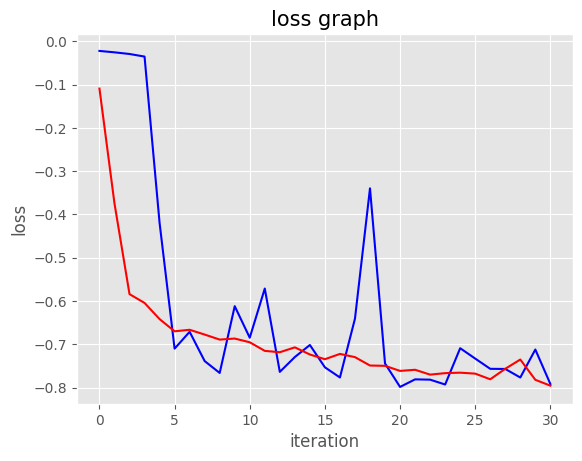

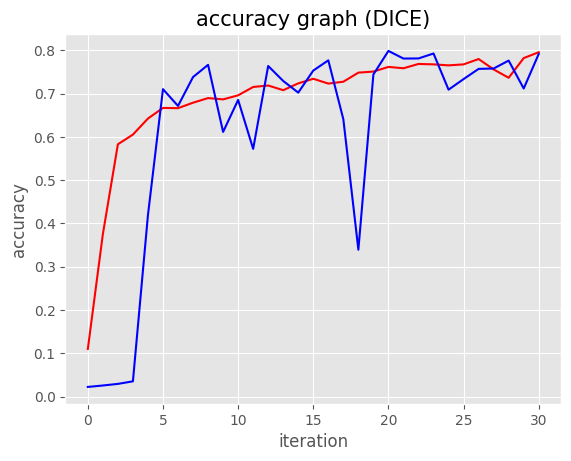

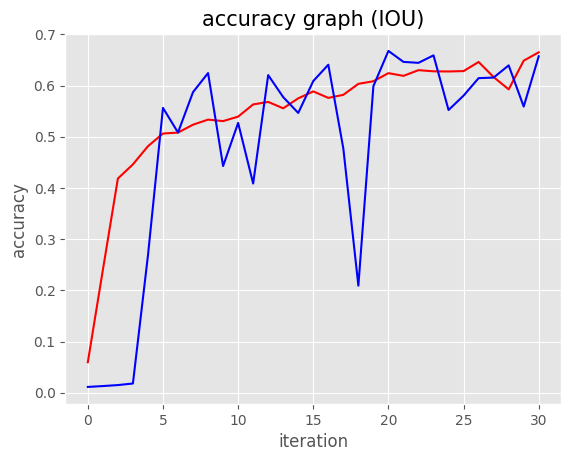

In [20]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph (DICE)', fontsize = 15)
plt.figure(3)
plt.plot(list_trainjaccard, 'r-')
plt.plot(list_testjaccard, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph (IOU)', fontsize = 15)
plt.show()
# Red = Training
# Blue = Validation

* Using the model in a test set

In [21]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
9/9 [==============================] - 17s 2s/step - loss: -0.7048 - binary_accuracy: 0.9950 - iou: 0.5532 - dice_coef: 0.7087
Test lost:  -0.7047756910324097
Test IOU:  0.9950016140937805
Test Dice Coefficent:  0.5532182455062866


* Testing on some samples

1/1 [==============================] - 3s 3s/step


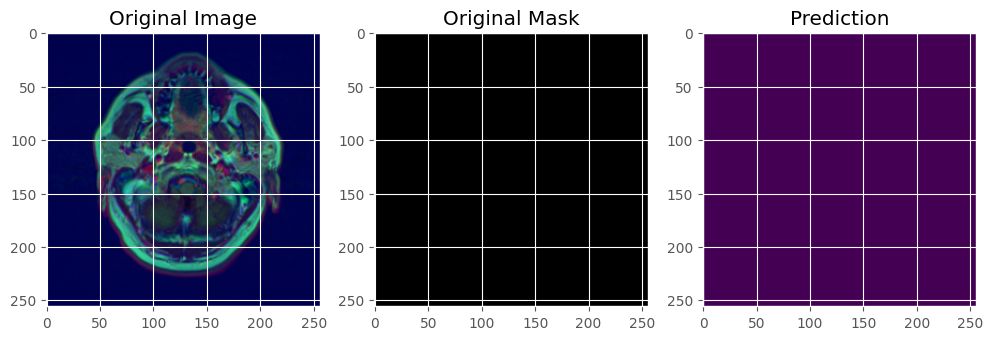

1/1 [==============================] - 0s 19ms/step


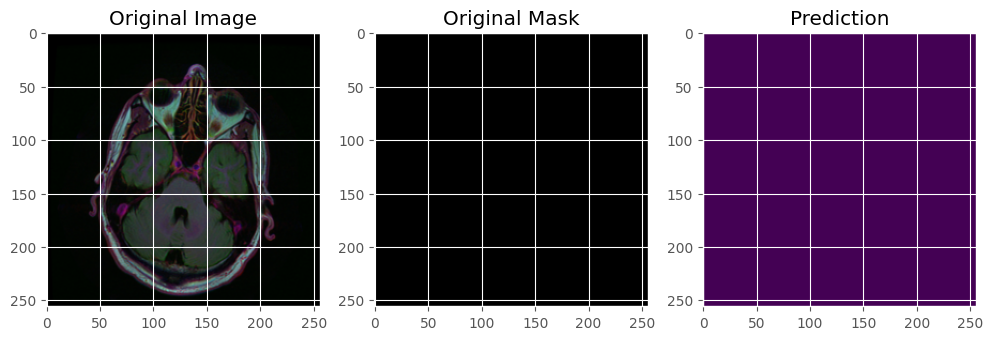

1/1 [==============================] - 0s 20ms/step


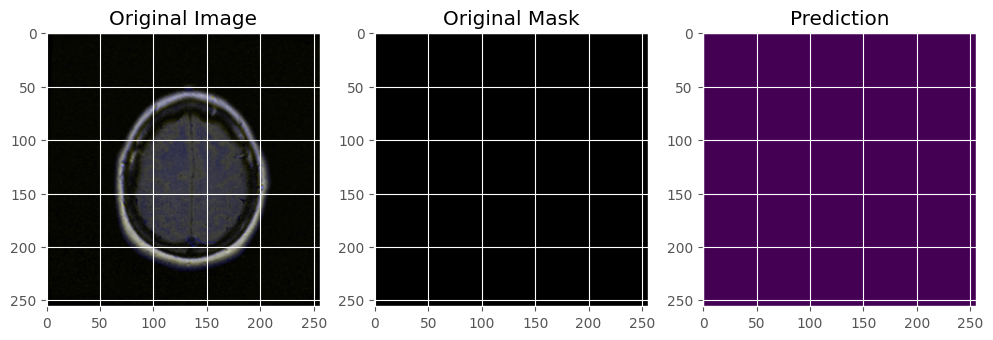

1/1 [==============================] - 0s 19ms/step


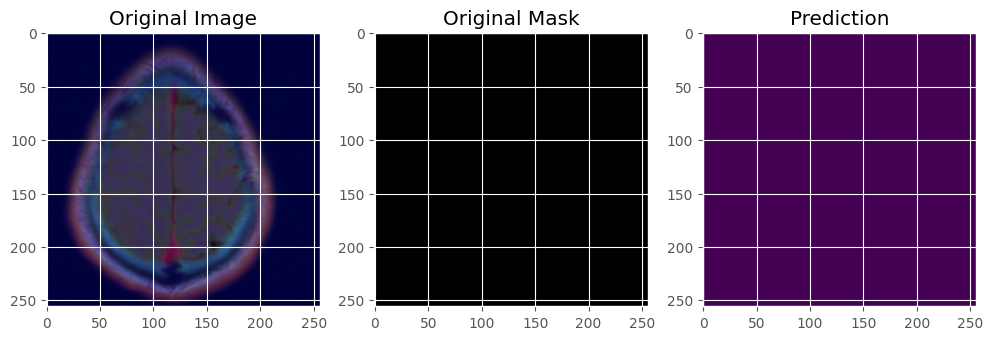

1/1 [==============================] - 0s 20ms/step


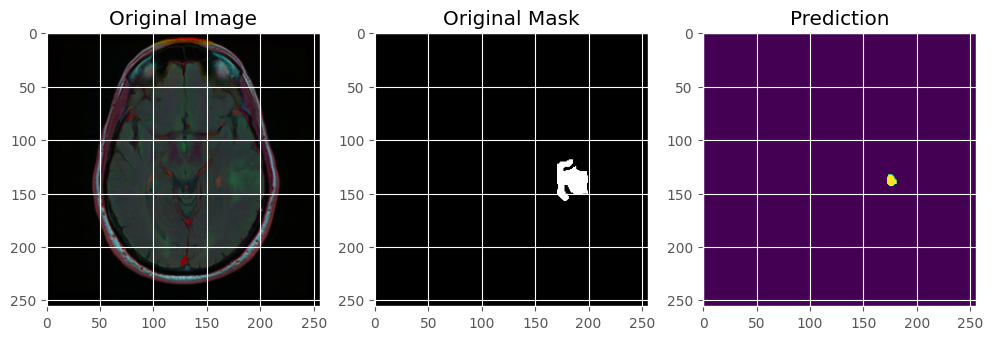

1/1 [==============================] - 0s 20ms/step


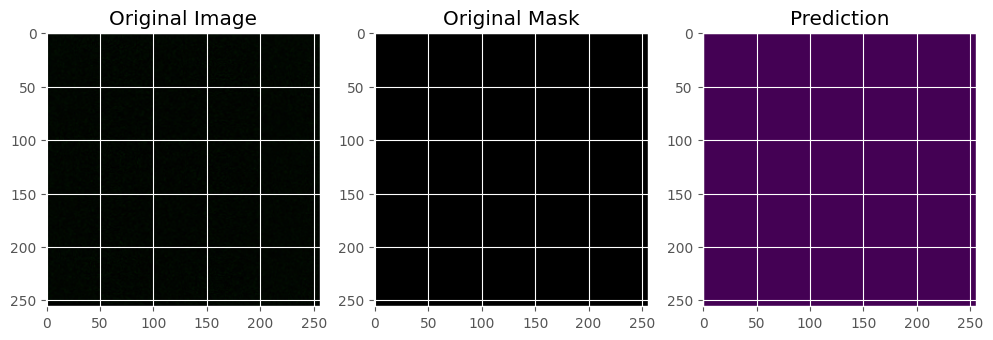

1/1 [==============================] - 0s 20ms/step


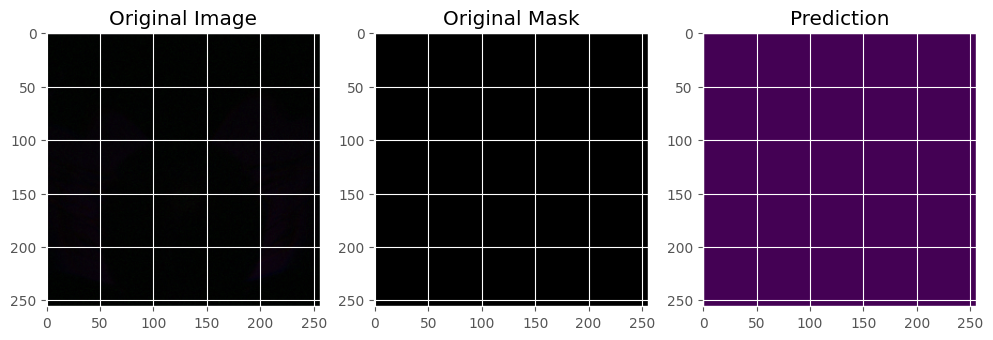

1/1 [==============================] - 0s 21ms/step


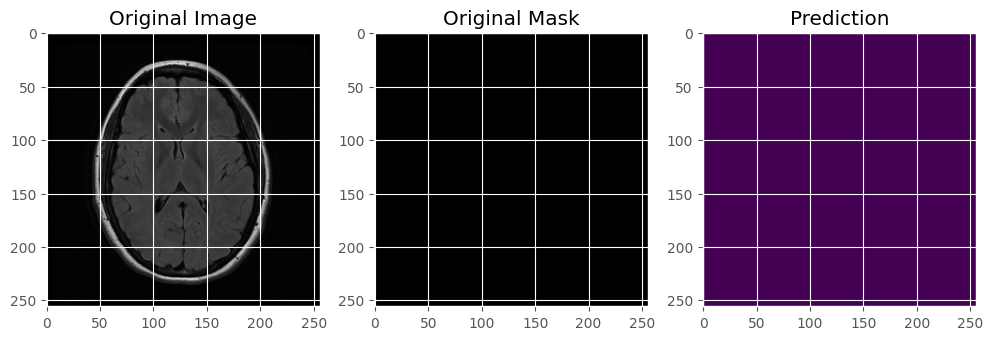

1/1 [==============================] - 0s 21ms/step


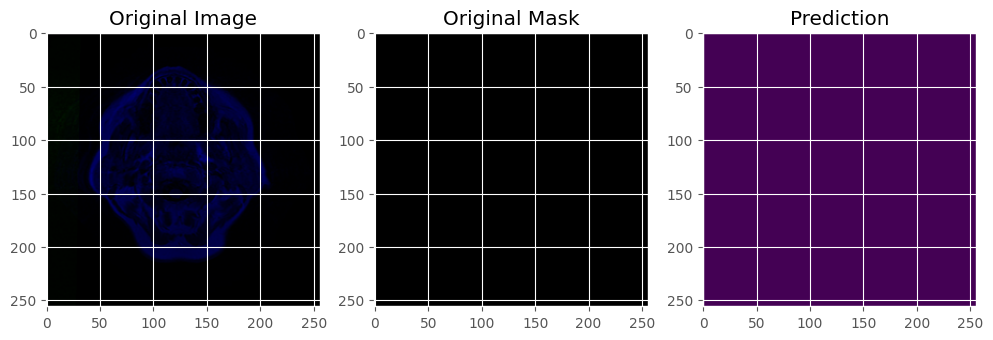

1/1 [==============================] - 0s 25ms/step


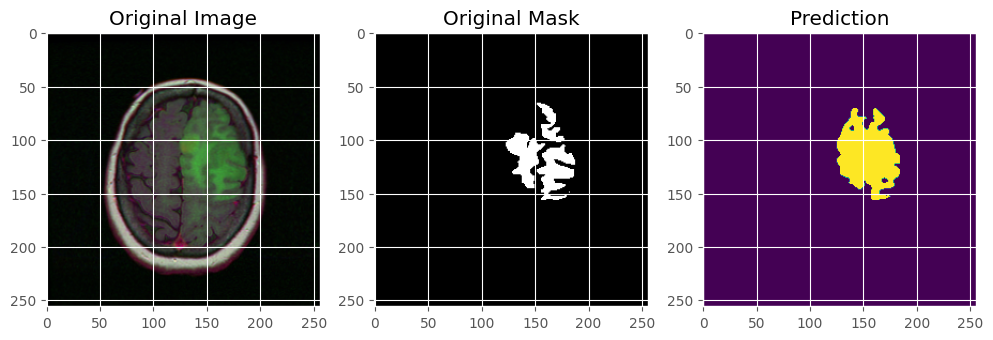

1/1 [==============================] - 0s 20ms/step


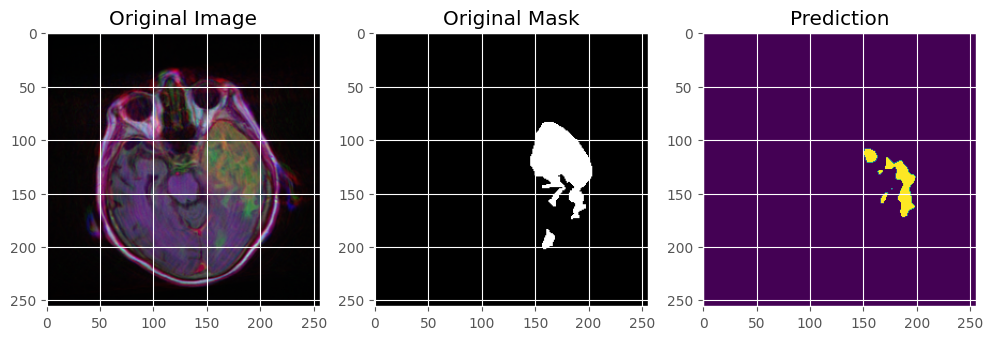

1/1 [==============================] - 0s 32ms/step


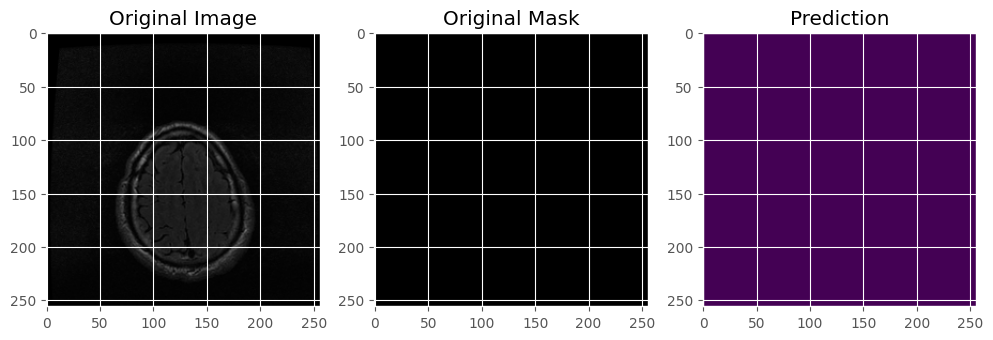

1/1 [==============================] - 0s 28ms/step


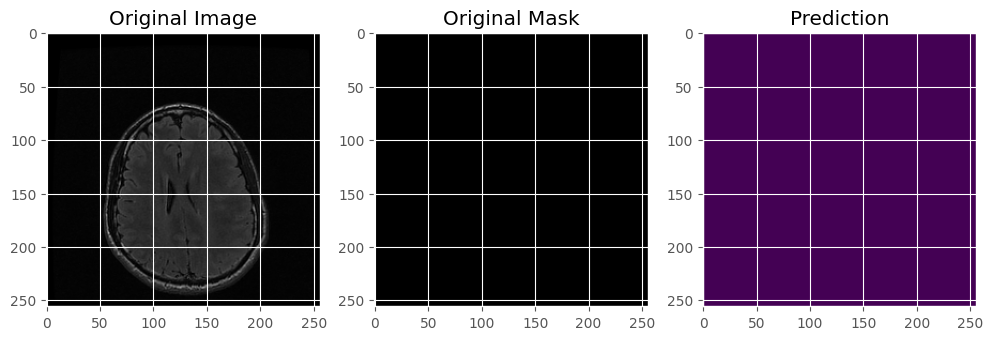

1/1 [==============================] - 0s 50ms/step


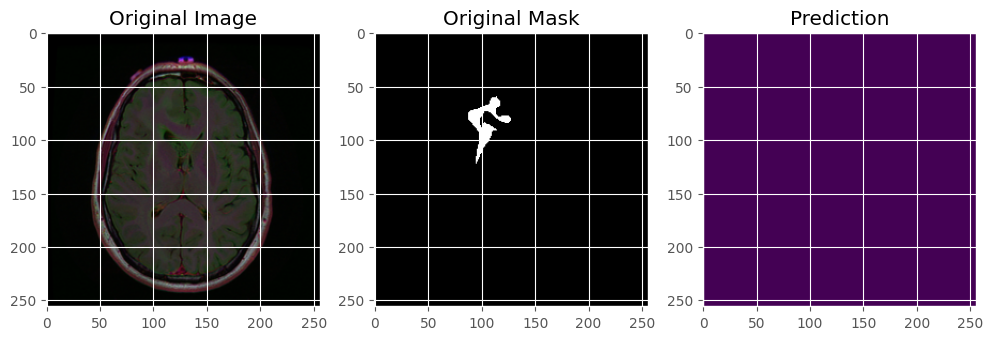

1/1 [==============================] - 0s 29ms/step


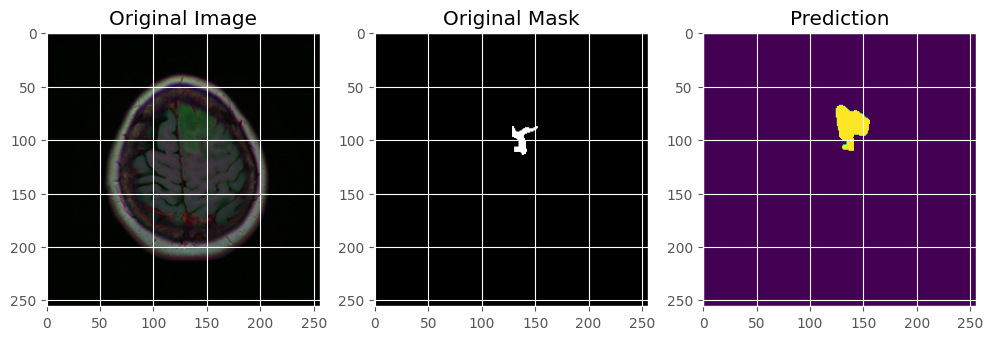

1/1 [==============================] - 0s 42ms/step


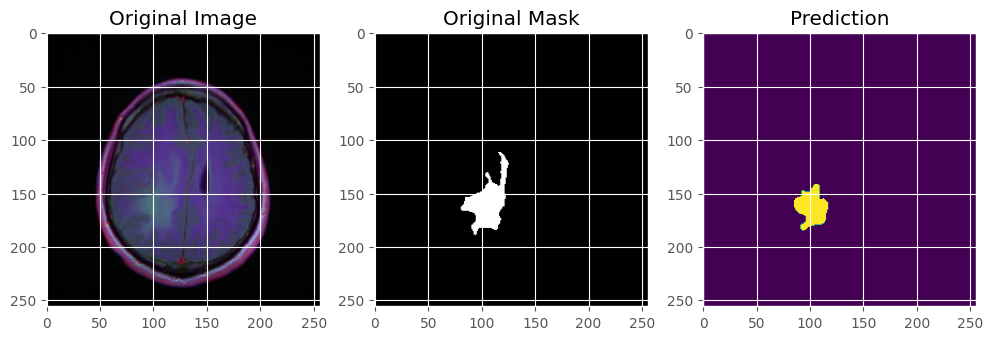

1/1 [==============================] - 0s 23ms/step


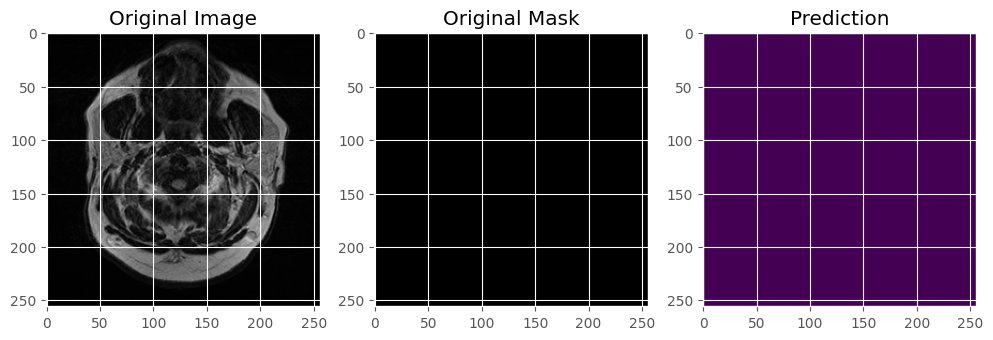

1/1 [==============================] - 0s 24ms/step


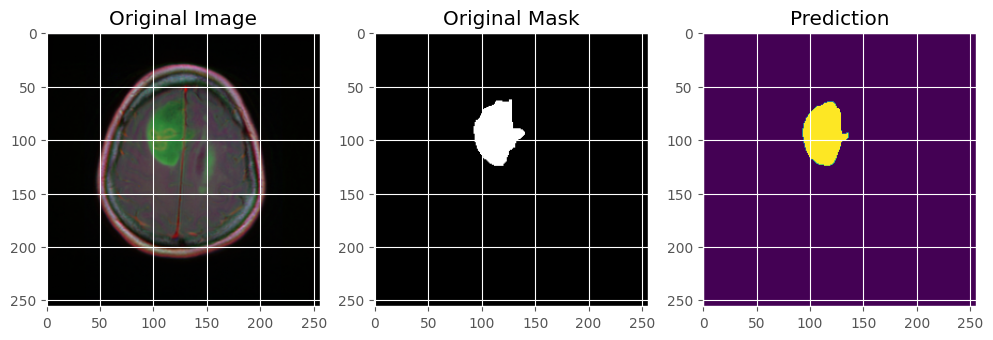

1/1 [==============================] - 0s 21ms/step


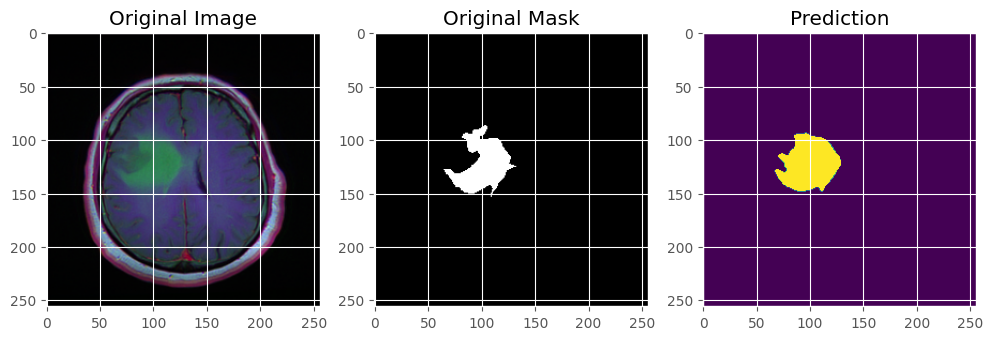

1/1 [==============================] - 0s 25ms/step


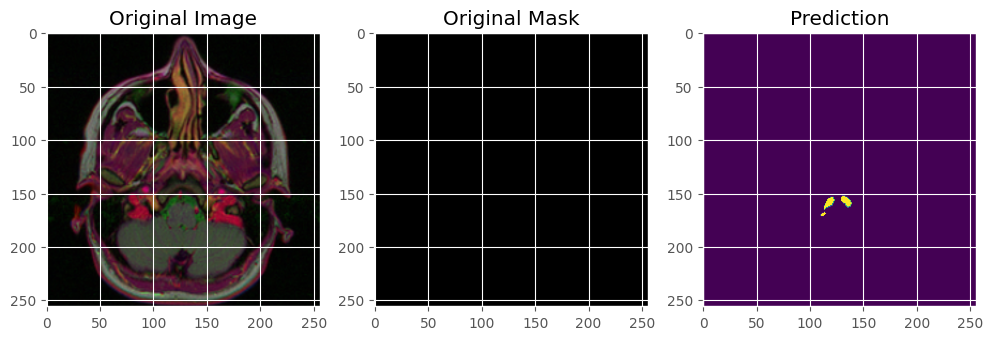

1/1 [==============================] - 0s 30ms/step


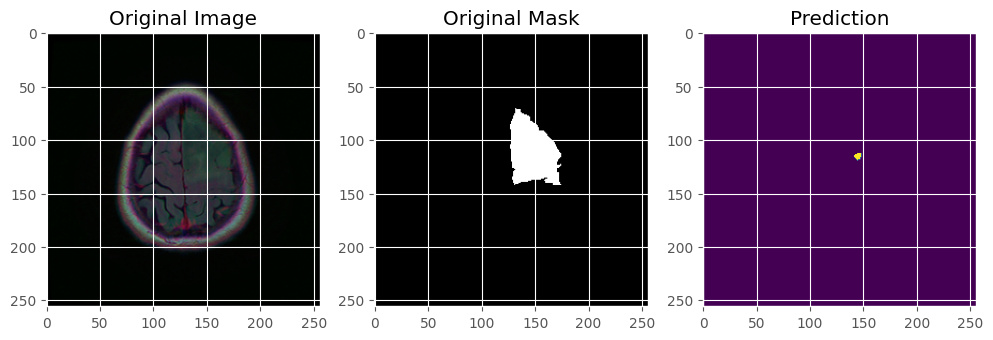

1/1 [==============================] - 0s 25ms/step


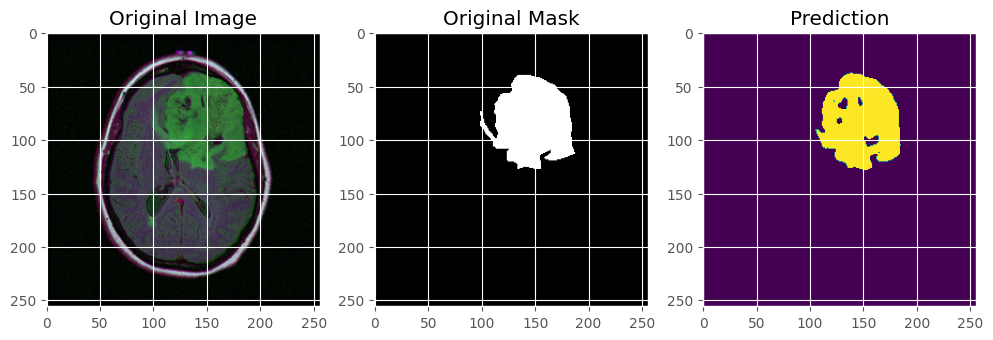

1/1 [==============================] - 0s 30ms/step


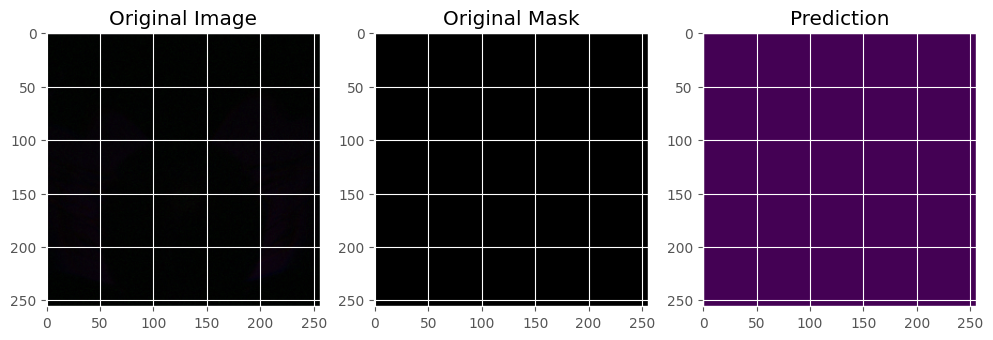

1/1 [==============================] - 0s 28ms/step


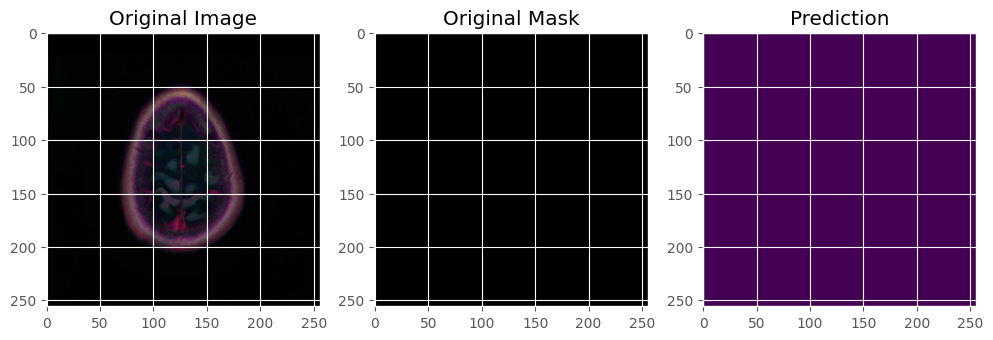

1/1 [==============================] - 0s 25ms/step


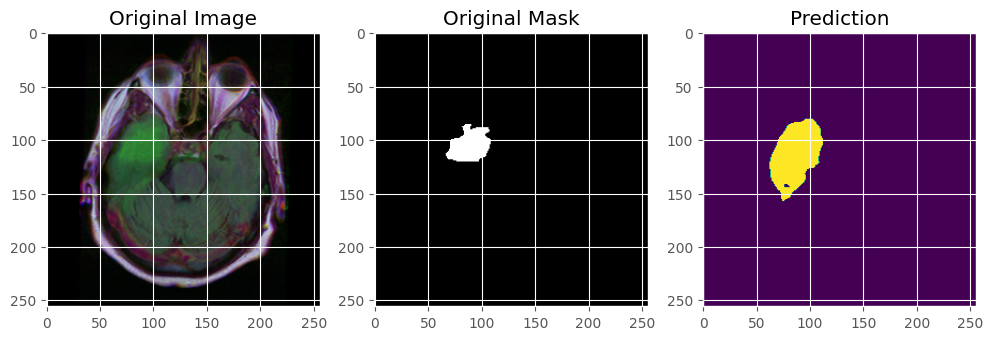

1/1 [==============================] - 0s 27ms/step


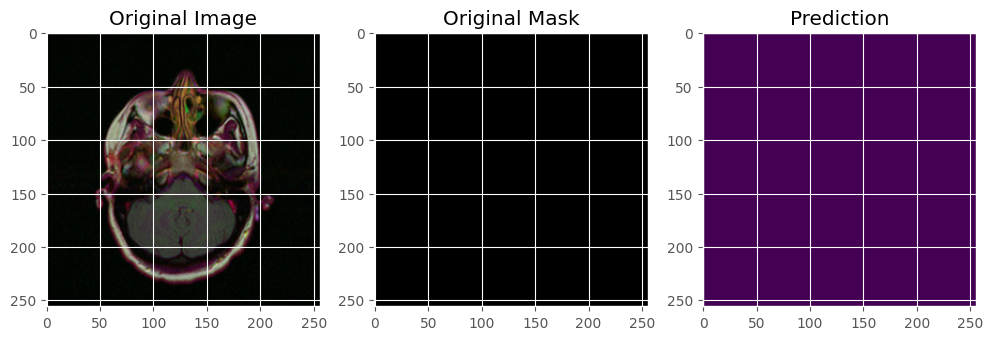

1/1 [==============================] - 0s 30ms/step


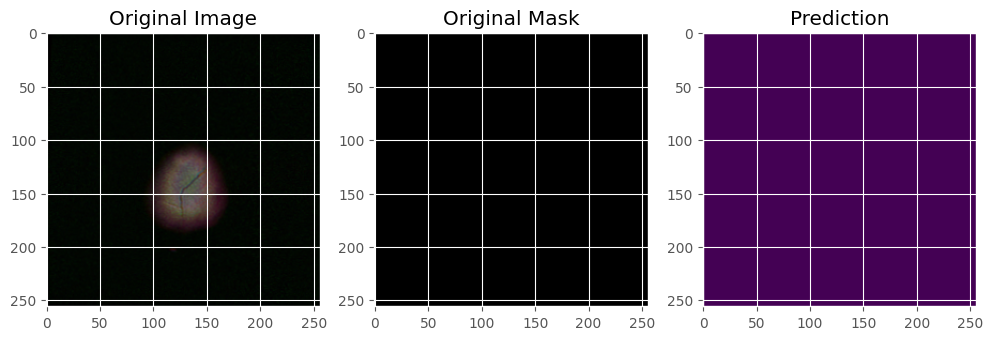

1/1 [==============================] - 0s 35ms/step


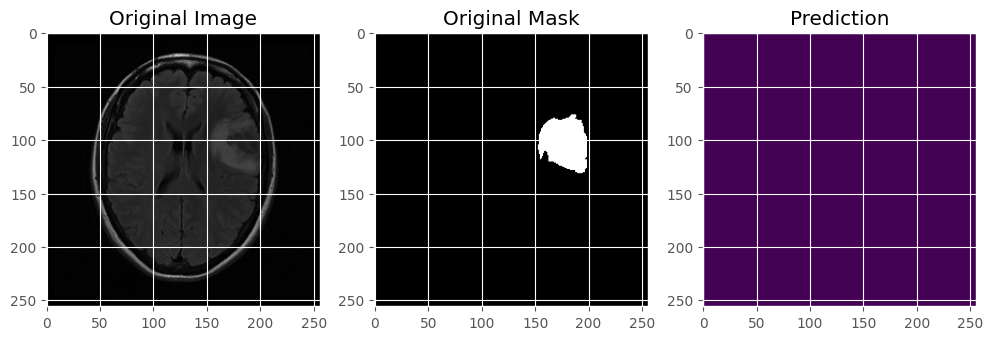

1/1 [==============================] - 0s 24ms/step


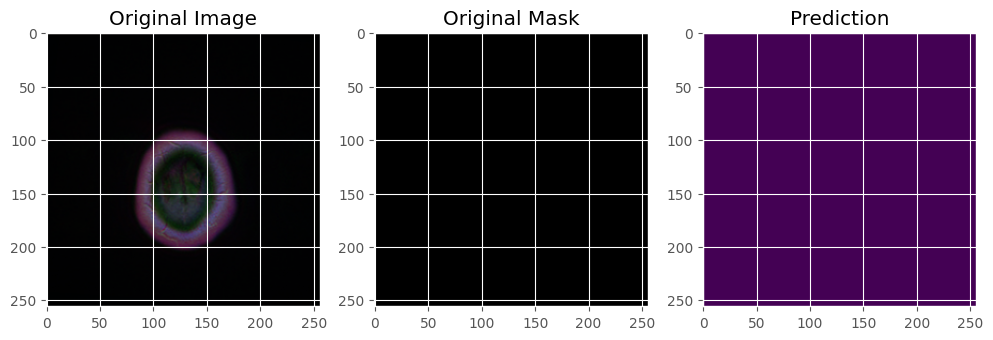

1/1 [==============================] - 0s 24ms/step


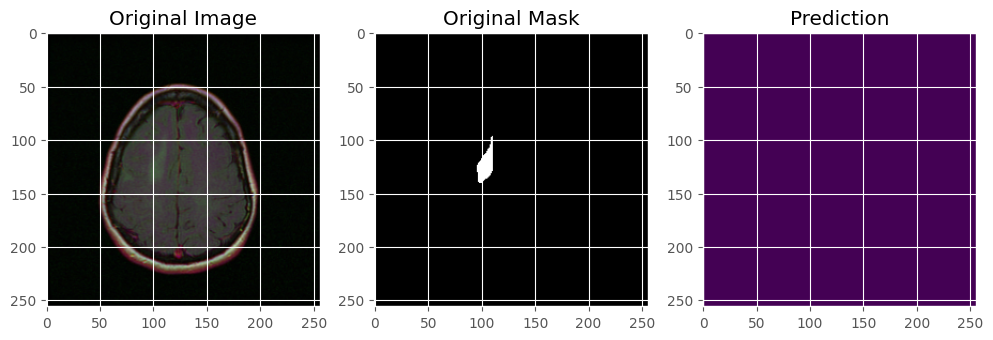

In [22]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

# References

1.   RONNEBERGER, O.; FISCHER, P.; BROX, T. U-Net: Convolutional Networks for Biomedical Image Segmentation. arXiv preprint arXiv:1505.04597, 2015.

2.   Zheng, P., Zhu, X. & Guo, W. Brain tumour segmentation based on an improved U-Net. BMC Med Imaging 22, 199 (2022).